In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch

np.random.seed(1)
torch.random.manual_seed(1)

In [14]:
#load data
data = pd.read_excel('Welding_Data.xlsx') #using pandas to load the excel file
data = data.dropna(axis=0, how='any') #drop nan from the data

# prepare variables and target
X = data.loc[:,['Current','Angle','Speed']] #Variables, or using data.iloc[:,1:4]
Y = data.loc[:,'Height'] # Target
X = X.to_numpy() #convert data frame to numpy array
Y = Y.to_numpy()

# data normalization, normalization to [0 1] range
X_Norm = np.empty_like(X)
for i in range(X.shape[1]):
   data_ = X[:,i]
   X_Norm[:,i] = (data_-np.amin(data_))/(np.amax(data_)-np.amin(data_)) 
    
# normalize Y data
Y_Min = np.amin(Y)
Y_Max = np.amax(Y)
Y_Norm = (Y-Y_Min)/(Y_Max-Y_Min)
Y_Norm = Y_Norm.reshape(len(Y_Norm),1)

In [15]:
# split training and testing data

index = np.arange(len(Y_Norm))
np.random.shuffle(index) #disorder the original data

m = np.ceil(0.7*len(Y)) # 70% for training and 30% for testing
m = int(m) #covert float type to int type
X_Train = X_Norm[index[:m]]
Y_Train = Y_Norm[index[:m]]

X_Test = X_Norm[index[m:]]
Y_Test = Y_Norm[index[m:]]

In [16]:
# convert numpy array to torch tensor
X_Train_Tensor = torch.tensor(X_Train).float()
X_Test_Tensor = torch.tensor(X_Test).float()
Y_Train_Tensor = torch.tensor(Y_Train).float()
Y_Test_Tensor = torch.tensor(Y_Test).float()

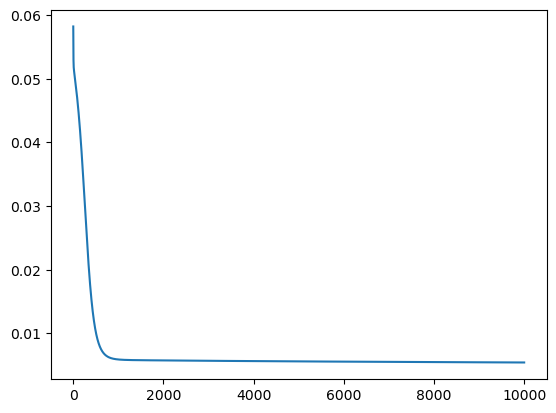

In [17]:
class Net(torch.nn.Module):
    def __init__(self, layer_numbers):
        super().__init__()
        self.hidden = torch.nn.Linear(layer_numbers[0],layer_numbers[1],bias = False)
        self.output = torch.nn.Linear(layer_numbers[1],layer_numbers[2],bias = False)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden(x) 
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

layer_numbers = [3,10,1]
epochs = 10000
net = Net(layer_numbers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.5)
loss_history = np.zeros(epochs)

for epoch in range(epochs):
    #forward process
    Y_pred = net(X_Train_Tensor)
    
    #loss
    loss = criterion(Y_pred,Y_Train_Tensor)
    #calculate gradients in backpropagation
    optimizer.zero_grad()
    loss.backward()
    #update weights
    optimizer.step()
    
    loss_history[epoch] = loss

plt.plot(np.arange(epochs),loss_history)  
        
    

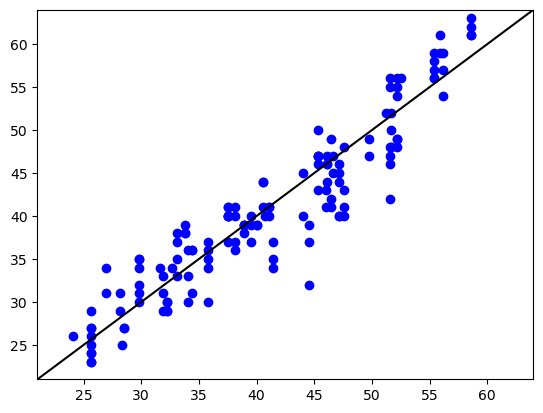

In [18]:
# testing 
y_predict = net(X_Test_Tensor)
y_predicted = y_predict.detach() * (Y_Max - Y_Min) + Y_Min
Y_Test = Y_Test_Tensor * (Y_Max - Y_Min) + Y_Min
plt.scatter(y_predicted, Y_Test, c = 'b',marker = 'o')
plt.xlim(Y_Min, Y_Max)
plt.ylim(Y_Min, Y_Max)
plt.plot([Y_Min, Y_Max],[Y_Min, Y_Max],'k-')

In [19]:
def r2(y_predicted,y):
 sst = np.sum((y-y.mean())**2)
 ssr = np.sum((y_predicted-y)**2)
 r2 = 1-(ssr/sst)
 return(r2)
r2(y_predicted.numpy(), Y_Test.numpy())

0.8700351864099503